<font size="+3">Time-series Generative Adversarial Network (TimeGAN)</font>

# Imports & Settings

Adapted from the excellent paper by Jinsung Yoon, Daniel Jarrett, and Mihaela van der Schaar:  
[Time-series Generative Adversarial Networks](https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks),  
Neural Information Processing Systems (NeurIPS), 2019.

- Last updated Date: April 24th 2020
- [Original code](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/alg/timegan/) author: Jinsung Yoon (jsyoon0823@gmail.com)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
sns.set_style('white')

# Data import

In [5]:
DATA_STORE = Path('/Users/philippebeliveau/Desktop/Notebook/GAN/Dataset.h5')

df = (pd.read_csv('/Users/philippebeliveau/Desktop/Notebook/GAN/Dataset/wiki_prices.csv',
                 parse_dates=['date'],
                 index_col=['date', 'ticker'],
                 infer_datetime_format=True)
     .sort_index())

print(df.info(null_counts=True))
with pd.HDFStore(DATA_STORE) as store:
    store.put('quandl/wiki/prices', df)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 15389314 entries, (Timestamp('1962-01-02 00:00:00'), 'ARNC') to (Timestamp('2018-03-27 00:00:00'), 'ZUMZ')
Data columns (total 12 columns):
 #   Column       Non-Null Count     Dtype  
---  ------       --------------     -----  
 0   open         15388776 non-null  float64
 1   high         15389259 non-null  float64
 2   low          15389259 non-null  float64
 3   close        15389313 non-null  float64
 4   volume       15389314 non-null  float64
 5   ex-dividend  15389314 non-null  float64
 6   split_ratio  15389313 non-null  float64
 7   adj_open     15388776 non-null  float64
 8   adj_high     15389259 non-null  float64
 9   adj_low      15389259 non-null  float64
 10  adj_close    15389313 non-null  float64
 11  adj_volume   15389314 non-null  float64
dtypes: float64(12)
memory usage: 1.4+ GB
None


# Experiment Path

In [6]:
results_path = Path('time_gan')
if not results_path.exists():
    results_path.mkdir()

In [7]:
experiment = 0

In [8]:
log_dir = results_path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

In [9]:
hdf_store = results_path / 'TimeSeriesGAN.h5'

# Prepare Data

## Parameters

In [10]:
seq_len = 24
n_seq = 6
batch_size = 128

In [11]:
tickers = ['BA', 'CAT', 'DIS', 'GE', 'IBM', 'KO']

In [12]:
def select_data():
    df = (pd.read_hdf('/Users/philippebeliveau/Desktop/Notebook/GAN/Dataset.h5', 'quandl/wiki/prices')
          .adj_close
          .unstack('ticker')
          .loc['2000':, tickers]
          .dropna())
    df.to_hdf(hdf_store, 'data/real')

In [13]:
select_data()

In [14]:
df.head()

open    high     low   close   volume  ex-dividend  \
date       ticker                                                         
1962-01-02 ARNC     65.56   65.75   65.38   65.38   5600.0          0.0   
           BA       50.88   50.88   50.00   50.00  11595.0          0.0   
           CAT      38.50   38.87   38.12   38.50  13600.0          0.0   
           DD      241.50  244.25  241.50  241.50   2000.0          0.0   
           DIS      37.25   38.50   37.25   37.25   2098.0          0.0   

                   split_ratio  adj_open  adj_high   adj_low  adj_close  \
date       ticker                                                         
1962-01-02 ARNC            1.0  3.458163  3.468185  3.448668   3.448668   
           BA              1.0  0.887160  0.887160  0.871816   0.871816   
           CAT             1.0  1.578370  1.593539  1.562791   1.578370   
           DD              1.0  4.718414  4.772144  4.718414   4.718414   
           DIS             1.0  0.141259  0.145999  0.141259   0.141259   

                   adj_volume  
date       ticker              
1962-01-02 ARNC     44800.000  
           BA      352198.125  
           CAT     163200.000  
           DD       36000.000  
           DIS     408858.240

## Plot Series

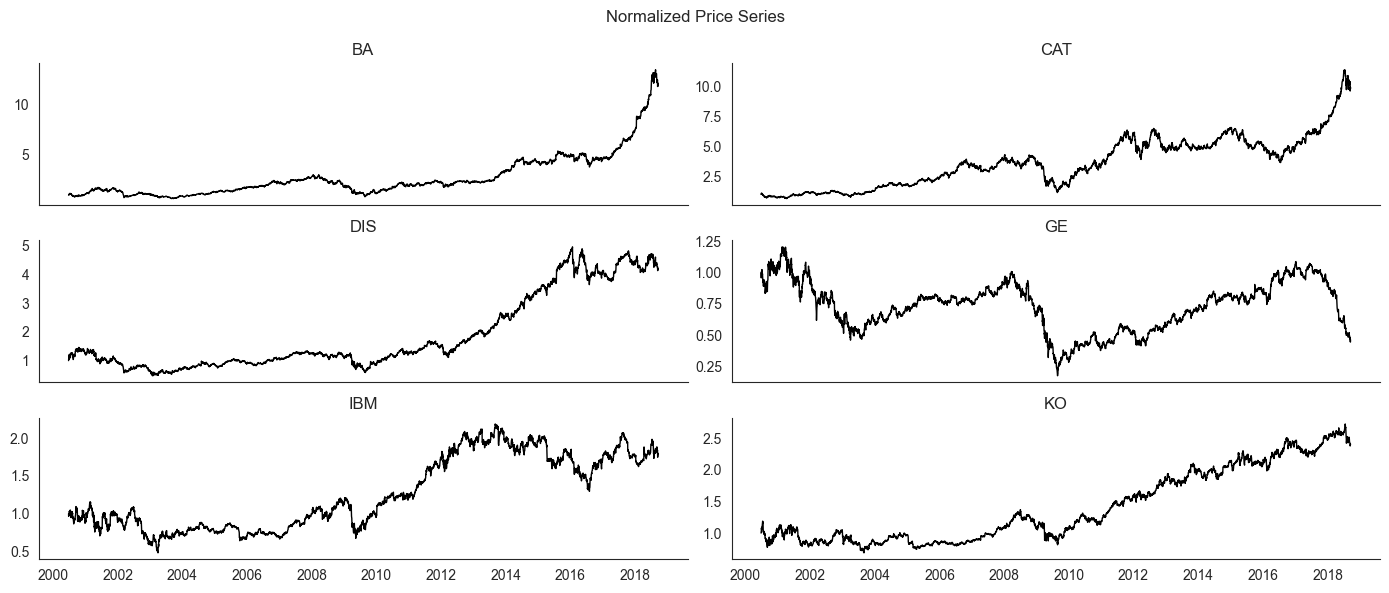

In [15]:
df = pd.read_hdf(hdf_store, 'data/real')
axes = df.div(df.iloc[0]).plot(subplots=True,
                               figsize=(14, 6),
                               layout=(3, 2),
                               title=tickers,
                               legend=False,
                               rot=0,
                               lw=1, 
                               color='k')
for ax in axes.flatten():
    ax.set_xlabel('')

plt.suptitle('Normalized Price Series')
plt.gcf().tight_layout()
sns.despine();

In [16]:
len(df['BA'])

4586

## Correlation

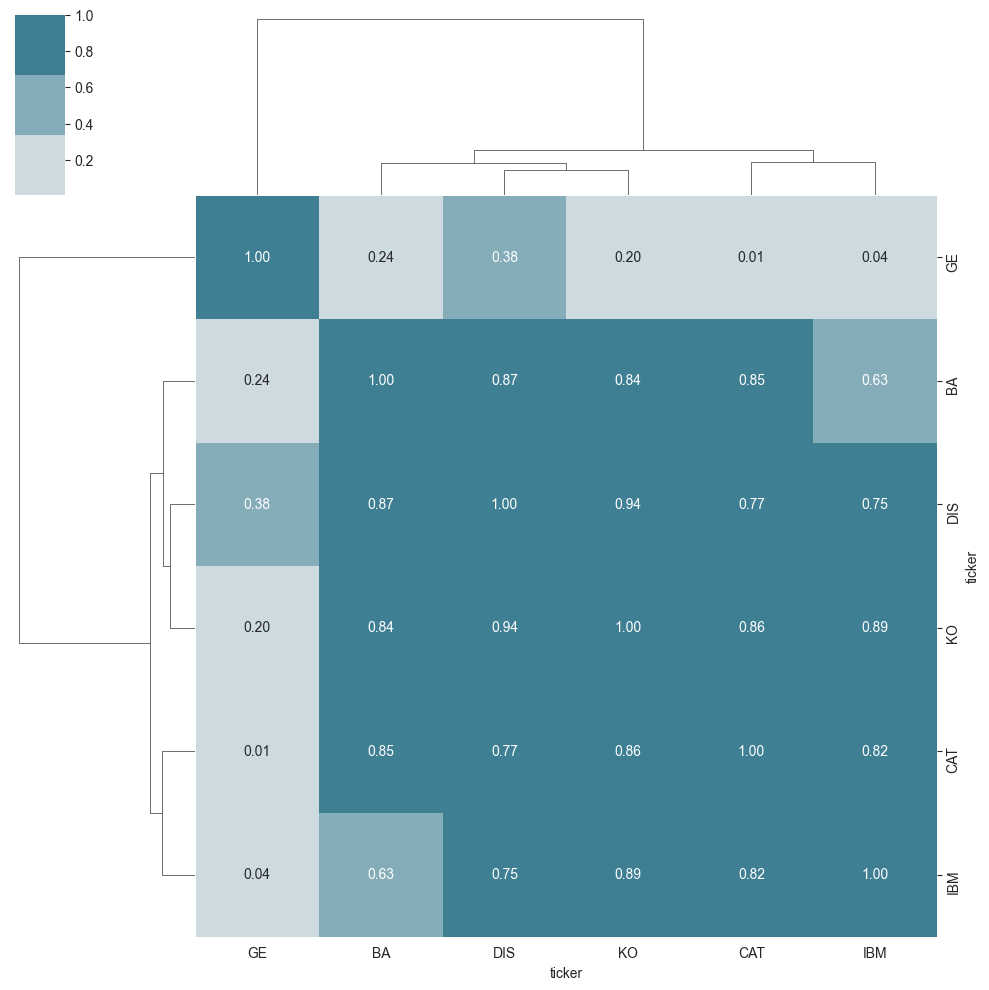

In [17]:
sns.clustermap(df.corr(),
               annot=True,
               fmt='.2f',
               cmap=sns.diverging_palette(h_neg=20,
                                          h_pos=220), center=0);

## Normalize Data

In [18]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

## Create rolling window sequences

In [19]:
data = []
for i in range(len(df) - seq_len):
    data.append(scaled_data[i:i + seq_len])

n_windows = len(data)

In [20]:
data[0].shape

print(len(data))

print(data[0])
print(data[1])
print(data[2])

4562
[[0.0270153  0.0338843  0.11736834 0.7995657  0.30353877 0.15350473]
 [0.0268983  0.03268138 0.13042037 0.7608107  0.28364336 0.15515795]
 [0.03237763 0.03613739 0.13877366 0.75919586 0.30353877 0.1605527 ]
 [0.03261162 0.03961251 0.13042037 0.77159745 0.29343957 0.16003063]
 [0.03504904 0.0428203  0.12669122 0.80802715 0.29091477 0.19266014]
 [0.03384008 0.03947885 0.16211815 0.8076396  0.31363794 0.1757798 ]
 [0.03249462 0.03793224 0.16487771 0.8092544  0.31868753 0.1931822 ]
 [0.03261162 0.03961251 0.14578447 0.81248397 0.32121232 0.19918603]
 [0.03128566 0.04068178 0.15413776 0.8237875  0.31490034 0.1910069 ]
 [0.03444456 0.04020442 0.1448149  0.80602485 0.3218183  0.1953575 ]
 [0.0363945  0.03700617 0.1518257  0.7866473  0.30227634 0.22964023]
 [0.04152283 0.03579542 0.15369026 0.7912979  0.32121232 0.23181553]
 [0.0393194  0.03160584 0.14533697 0.7733414  0.31868753 0.23729728]
 [0.03773995 0.03208629 0.13877366 0.7616504  0.33131152 0.24599849]
 [0.03504904 0.02810811 0.142

## Create tf.data.Dataset

In [21]:
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle(buffer_size=n_windows)
               .batch(batch_size))
real_series_iter = iter(real_series.repeat())

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [22]:
# Show me the length of the real series
print(len(real_series))

x = 36*128 
print(x)

36
4608


## Set up random series generator

In [24]:
def make_random_data():
    while True:
        
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

We use the Python generator to feed a `tf.data.Dataset` that continues to call the random number generator as long as necessary and produces the desired batch size.

In [25]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

In [26]:
# Show me how many random series we hav
next(random_series).shape

TensorShape([128, 24, 6])

In [27]:
next(random_series).shape

TensorShape([128, 24, 6])

# TimeGAN Components

The design of the TimeGAN components follows the author's sample code.

##  Network Parameters

In [28]:
hidden_dim = 24
num_layers = 3

## Set up logger

In [29]:
writer = tf.summary.create_file_writer(log_dir.as_posix())

## Input place holders

In [30]:
X = Input(shape=[seq_len, n_seq], name='RealData')
Z = Input(shape=[seq_len, n_seq], name='RandomData')

## RNN block generator

We keep it very simple and use a very similar architecture for all four components. For a real-world application, they should be tailored to the data.

In [31]:
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                           return_sequences=True,
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

## Embedder & Recovery

In [32]:
embedder = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim, 
                    name='Embedder')
recovery = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=n_seq, 
                    name='Recovery')

## Generator & Discriminator

In [33]:
generator = make_rnn(n_layers=3, 
                     hidden_units=hidden_dim, 
                     output_units=hidden_dim, 
                     name='Generator')
discriminator = make_rnn(n_layers=3, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name='Discriminator')
supervisor = make_rnn(n_layers=2, 
                      hidden_units=hidden_dim, 
                      output_units=hidden_dim, 
                      name='Supervisor')

# TimeGAN Training

## Settings

In [34]:
train_steps = 100
gamma = 1

## Generic Loss Functions

In [35]:
mse = MeanSquaredError()
bce = BinaryCrossentropy()

# Phase 1: Autoencoder Training

## Architecture

In [36]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name='Autoencoder')

In [37]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 6)]           0         
                                                                 
 Embedder (Sequential)       (None, 24, 24)            10104     
                                                                 
 Recovery (Sequential)       (None, 24, 6)             10950     
                                                                 
Total params: 21,054
Trainable params: 21,054
Non-trainable params: 0
_________________________________________________________________


In [38]:
plot_model(autoencoder,
           to_file=(results_path / 'autoencoder.png').as_posix(),
           show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## Autoencoder Optimizer

In [39]:
autoencoder_optimizer = Adam()

## Autoencoder Training Step

In [40]:
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Autoencoder Training Loop

In [41]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

100%|██████████| 100/100 [00:26<00:00,  3.83it/s]


## Persist model

In [42]:
# autoencoder.save(log_dir / 'autoencoder')

# Phase 2: Supervised training

## Define Optimizer

In [43]:
supervisor_optimizer = Adam()

## Train Step

In [44]:
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, :-1, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

## Training Loop

In [45]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


## Persist Model

In [46]:
# supervisor.save(log_dir / 'supervisor')

# Joint Training

## Generator

### Adversarial Architecture - Supervised

In [47]:
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [48]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 6)]           0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            10104     
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 28,729
Trainable params: 28,729
Non-trainable params: 0
_________________________________________________________________


In [49]:
plot_model(adversarial_supervised, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### Adversarial Architecture in Latent Space

In [50]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')

In [51]:
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 6)]           0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            10104     
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 20,929
Trainable params: 20,929
Non-trainable params: 0
_________________________________________________________________


In [52]:
plot_model(adversarial_emb, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### Mean & Variance Loss

In [53]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name='SyntheticData')

In [54]:
synthetic_data.summary()

Model: "SyntheticData"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 6)]           0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            10104     
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Recovery (Sequential)       (None, 24, 6)             10950     
                                                                 
Total params: 28,854
Trainable params: 28,854
Non-trainable params: 0
_________________________________________________________________


In [55]:
plot_model(synthetic_data, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [56]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

## Discriminator

### Architecture: Real Data

In [57]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')

In [58]:
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 6)]           0         
                                                                 
 Embedder (Sequential)       (None, 24, 24)            10104     
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 20,929
Trainable params: 20,929
Non-trainable params: 0
_________________________________________________________________


In [59]:
plot_model(discriminator_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## Optimizers

In [60]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

## Generator Train Step

In [61]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

## Embedding Train Step

In [62]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Discriminator Train Step

In [63]:
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

In [64]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

## Training Loop

In [65]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4' 
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 10 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)

     0 | d_loss: 2.0783 | g_loss_u: 0.6636 | g_loss_s: 0.0052 | g_loss_v: 0.3195 | e_loss_t0: 0.1553
    10 | d_loss: 1.8488 | g_loss_u: 1.1765 | g_loss_s: 0.0054 | g_loss_v: 0.2953 | e_loss_t0: 0.1403
    20 | d_loss: 1.7065 | g_loss_u: 1.3019 | g_loss_s: 0.0073 | g_loss_v: 0.3308 | e_loss_t0: 0.1410
    30 | d_loss: 1.6720 | g_loss_u: 1.4903 | g_loss_s: 0.0088 | g_loss_v: 0.3076 | e_loss_t0: 0.1339
    40 | d_loss: 1.5505 | g_loss_u: 1.8680 | g_loss_s: 0.0076 | g_loss_v: 0.3590 | e_loss_t0: 0.1408
    50 | d_loss: 1.5527 | g_loss_u: 1.5697 | g_loss_s: 0.0063 | g_loss_v: 0.3413 | e_loss_t0: 0.1288
    60 | d_loss: 1.4865 | g_loss_u: 1.5684 | g_loss_s: 0.0078 | g_loss_v: 0.3663 | e_loss_t0: 0.1327
    70 | d_loss: 1.4330 | g_loss_u: 1.7272 | g_loss_s: 0.0065 | g_loss_v: 0.3331 | e_loss_t0: 0.1336
    80 | d_loss: 1.3281 | g_loss_u: 1.6755 | g_loss_s: 0.0056 | g_loss_v: 0.3070 | e_loss_t0: 0.1421
    90 | d_loss: 1.4138 | g_loss_u: 1.4962 | g_loss_s: 0.0093 | g_loss_v: 0.1901 | e_loss_t

## Persist Synthetic Data Generator

In [66]:
synthetic_data.save(log_dir / 'synthetic_data')

INFO:tensorflow:Assets written to: time_gan/experiment_00/synthetic_data/assets


INFO:tensorflow:Assets written to: time_gan/experiment_00/synthetic_data/assets


# Generate Synthetic Data

In [67]:
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [68]:
print(generated_data[0].shape)
print(len(generated_data))

print(128*35)
print(4480/24)

print(len(df))

(128, 24, 6)
35
4480
186.66666666666666
4586


In [69]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(4480, 24, 6)

In [70]:
np.save(log_dir / 'generated_data.npy', generated_data)

## Rescale

In [71]:
generated_data = (scaler.inverse_transform(generated_data
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
generated_data.shape

(4480, 24, 6)

In [72]:
print(generated_data[0])

[[124.080826  67.26348   55.63417   21.61437  106.681984  27.095322]
 [ 92.09995   57.686897  51.317265  22.15164  106.2234    26.076248]
 [ 77.66855   55.357376  49.67717   21.870338 110.445076  26.340961]
 [ 72.76132   58.373764  49.50747   21.052143 118.70005   27.523232]
 [ 72.47387   64.7665    49.59755   19.967815 128.86304   29.02042 ]
 [ 73.87969   72.16145   48.954205  18.863527 137.83936   30.149908]
 [ 75.26992   78.35718   46.80332   17.83352  143.924     30.489084]
 [ 75.84407   82.17141   42.830006  16.834354 146.99628   29.970716]
 [ 75.15033   82.76459   36.99937   15.818776 146.62886   28.617947]
 [ 72.662094  78.647575  29.597488  14.812851 140.74365   26.346388]
 [ 67.96038   70.46188   23.571852  14.15243  128.94484   23.597805]
 [ 60.842968  61.315327  21.483282  14.441919 115.51839   21.29923 ]
 [ 54.04512   53.139812  21.21341   15.255505 104.614075  19.89473 ]
 [ 49.89924   48.353973  21.22683   15.897656  99.428825  19.432411]
 [ 47.250187  45.55823   21.338911

## Persist Data

In [73]:
with pd.HDFStore(hdf_store) as store:
    store.put('data/synthetic', pd.DataFrame(generated_data.reshape(-1, n_seq),
                                             columns=tickers))

## Plot sample Series

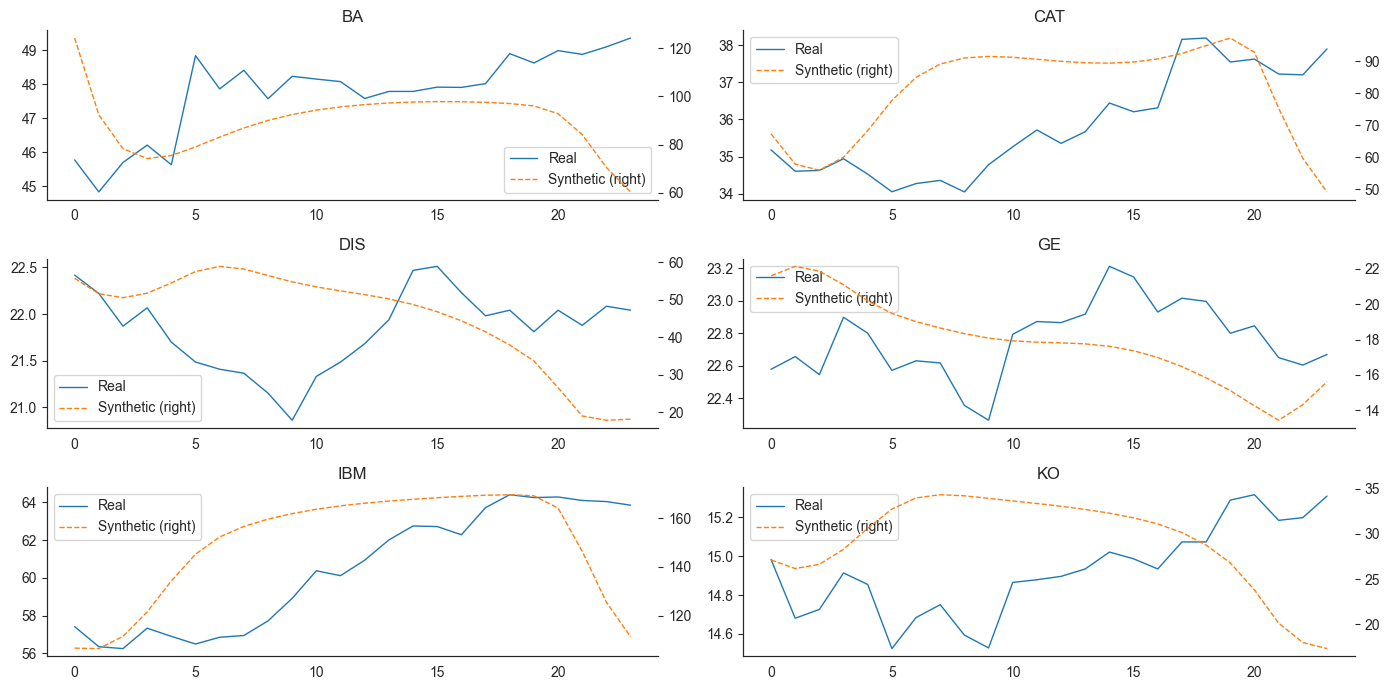

In [74]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
axes = axes.flatten()

index = list(range(1, 25))
synthetic = generated_data[np.random.randint(n_windows)]

idx = np.random.randint(len(df) - seq_len)
real = df.iloc[idx: idx + seq_len]

for j, ticker in enumerate(tickers):
    (pd.DataFrame({'Real': real.iloc[:, j].values,
                   'Synthetic': synthetic[:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1))
sns.despine()
fig.tight_layout()

In [75]:
generated_data.shape

(4480, 24, 6)

In [76]:
print(generated_data[143])

[[124.148964  67.32438   55.70771   21.612944 106.77252   27.120647]
 [ 92.37398   57.937614  51.64375   22.148838 106.655334  26.190485]
 [ 78.39746   56.096764  50.652836  21.87606  111.78279   26.687914]
 [ 74.400215  60.22926   51.919846  21.109854 121.87399   28.370049]
 [ 75.62268   68.492584  54.586575  20.201904 134.43155   30.663307]
 [ 79.03105   77.731445  57.229282  19.468428 145.07623   32.6596  ]
 [ 82.80398   84.87754   58.004787  18.939558 151.94887   33.717808]
 [ 86.170135  89.24842   56.55414   18.471624 156.20685   33.871655]
 [ 88.88902   91.66034   53.902817  18.00014  159.19159   33.490948]
 [ 90.952126  92.9883    50.952732  17.540594 161.50375   32.872128]
 [ 92.4388    93.835396  48.019463  17.104002 163.34656   32.138313]
 [ 93.430374  94.61626   45.07267   16.670153 164.80617   31.298685]
 [ 93.9659    95.63367   41.98378   16.20245  165.91698   30.307875]
 [ 93.99127   97.00782   38.62393   15.665478 166.62659   29.094036]
 [ 93.25393   98.18738   34.698666

3624


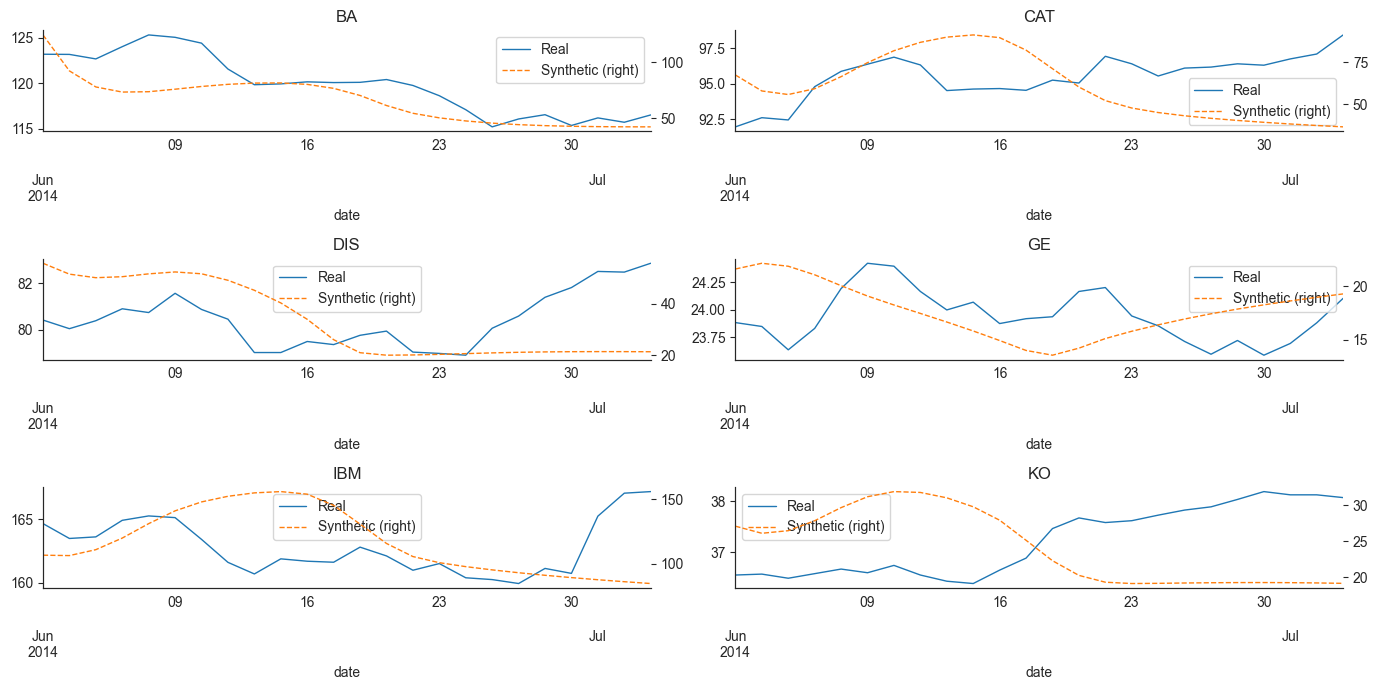

In [77]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
axes = axes.flatten()

index = list(range(1, 25))

obs = np.random.randint(len(df))
print(obs)


for j, ticker in enumerate(tickers):
    (pd.DataFrame({'Real': df.iloc[obs: obs + seq_len].iloc[:, j],
                   'Synthetic': generated_data[obs][:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1))
sns.despine()
fig.tight_layout()

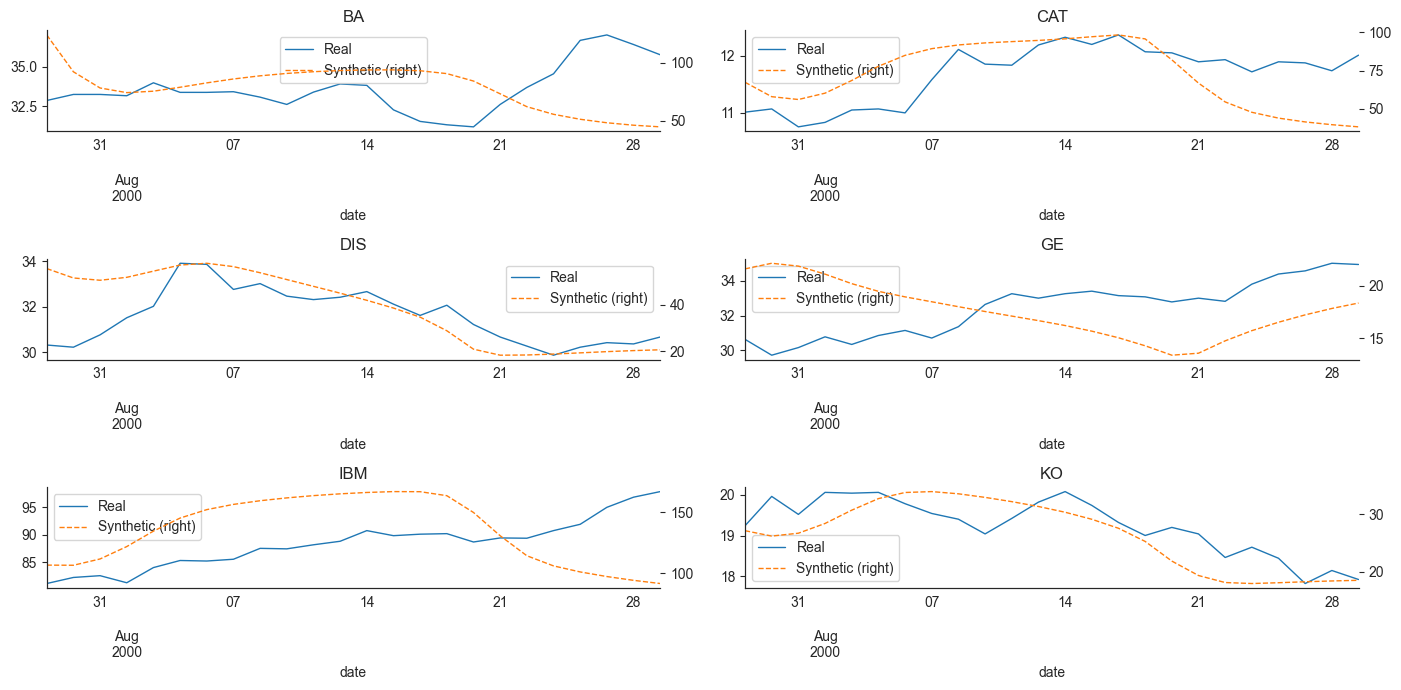

In [78]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
axes = axes.flatten()

index = list(range(1, 25))
# synthetic = generated_data[np.random.randint(n_windows)]

idx = 143
real = df.iloc[idx: idx + seq_len]

for j, ticker in enumerate(tickers):
    (pd.DataFrame({'Real': real.iloc[:, j],
                   'Synthetic': generated_data[idx][:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1))
sns.despine()
fig.tight_layout()